In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/39457_left.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/20882_right.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/7884_left._aug_18.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/1873_left._aug_2.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/26113_right.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/33956_left._aug_13.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/32216_right._aug_27.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/43609_left._aug_29.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/41076_right._aug_9.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/

In [2]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [3]:
train_df = "../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/" 
val_df = "../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/" 
test_df = "../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/" 

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 34792 images belonging to 5 classes.
Found 9940 images belonging to 5 classes.


In [6]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [7]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

234545216/234545216 [==============================] - 1s 0us/step


In [8]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

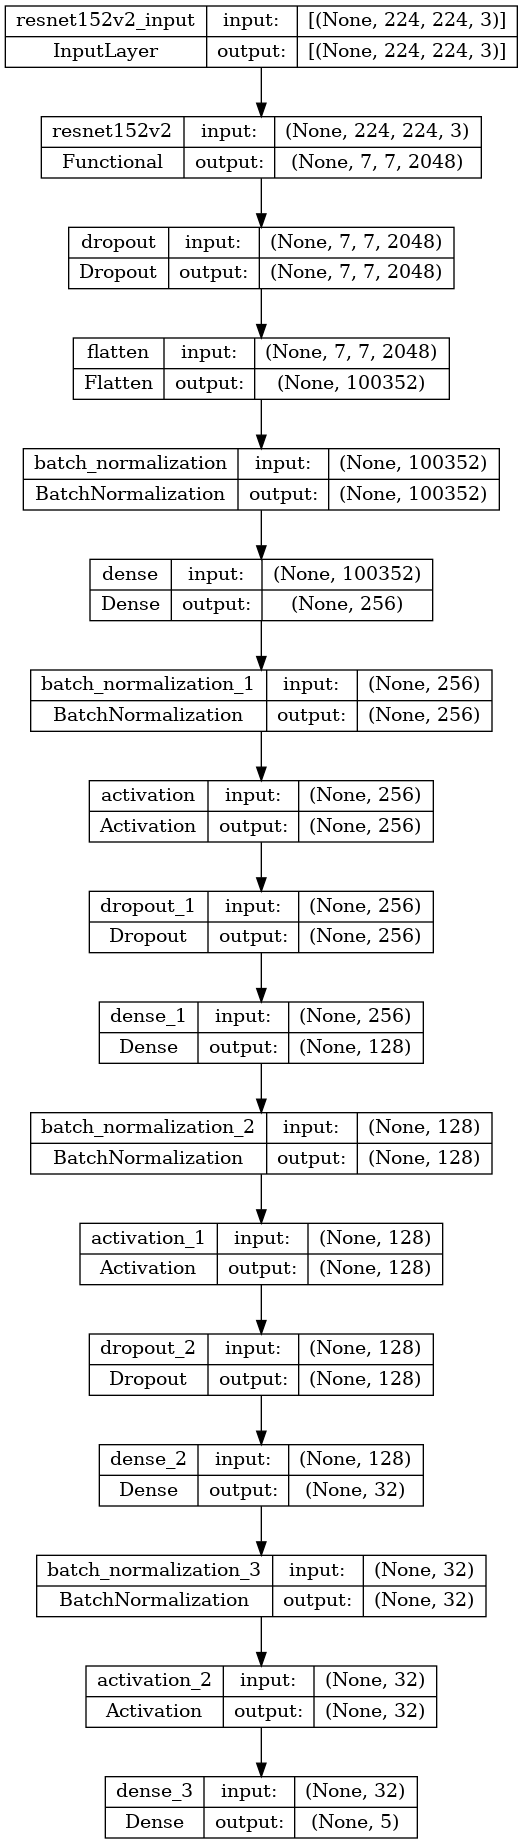

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
#     f1_score,
]


In [13]:
model.compile(
    optimizer='Adam', 
    loss="categorical_crossentropy",
     metrics=METRICS
)

# from keras.optimizers import Adam
# model.compile(
#     loss = 'categorical_crossentropy',
#     optimizer='Adam', 
#     metrics=['accuracy']
# )

In [14]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [15]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

3479
994


In [16]:
history=model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=100,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
)

Epoch 1/100
25/25 [==============================] - 86s 3s/step - loss: 1.8594 - accuracy: 0.7784 - auc: 0.5317 - val_loss: 57.9683 - val_accuracy: 0.6400 - val_auc: 0.4375
Epoch 2/100
25/25 [==============================] - 69s 3s/step - loss: 1.7322 - accuracy: 0.7800 - auc: 0.5623 - val_loss: 17.7979 - val_accuracy: 0.6800 - val_auc: 0.4950
Epoch 3/100
25/25 [==============================] - 68s 3s/step - loss: 1.6656 - accuracy: 0.7896 - auc: 0.6030 - val_loss: 4.3161 - val_accuracy: 0.7600 - val_auc: 0.6363
Epoch 4/100
25/25 [==============================] - 67s 3s/step - loss: 1.6375 - accuracy: 0.7904 - auc: 0.5957 - val_loss: 2.2469 - val_accuracy: 0.7800 - val_auc: 0.7412
Epoch 5/100
25/25 [==============================] - 68s 3s/step - loss: 1.6114 - accuracy: 0.8000 - auc: 0.6138 - val_loss: 3.2222 - val_accuracy: 0.7200 - val_auc: 0.5825
Epoch 6/100
25/25 [==============================] - 67s 3s/step - loss: 1.6559 - accuracy: 0.7920 - auc: 0.5980 - val_loss: 2.4504 -

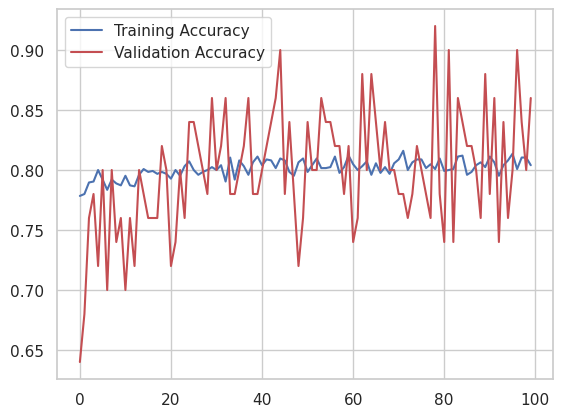

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

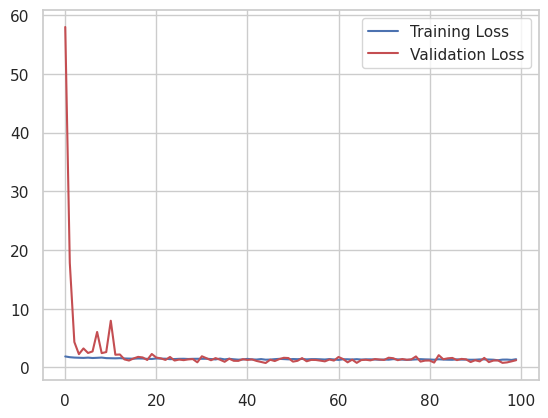

In [18]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.legend(loc = 'best')
plt.show()

In [19]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

test_generator = test_datagen.flow_from_directory(
    test_df,
    target_size = (224, 224),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 4971 images belonging to 5 classes.


In [20]:
model_save = ModelCheckpoint('./Model5.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [21]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

predict_x = model.predict(test_generator)

498/498 [==============================] - 1111s 2s/step


In [22]:
from sklearn.metrics import classification_report,confusion_matrix

In [23]:
# predictions = np.argmax(predict_x, axis = 1)
# predictions_ = predictions.reshape(1,-1)[0]
# print(classification_report(
#     test_generator.classes, 
#     predictions,
#     target_names=['No DR (Class 0)',
#                   'Mild (Class 1)',
#                   'Moderate (Class 2)', 
#                   'Severe (Class 3)',
#                   'Proliferative DR (Class 4)'
# ]))

In [24]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

994/994 [==============================] - 2225s 2s/step - loss: 1.2787 - accuracy: 0.8084 - auc: 0.7837
Train Loss:  1.292838454246521
Train Accuracy:  0.8066049814224243
--------------------
Validation Loss:  1.2786887884140015
Validation Accuracy:  0.8083500862121582
